In [1]:
using Revise
using CUDA
using BenchmarkTools
A = CUDA.rand(Float32, 1024, 1024);
B = CUDA.rand(Float32, 1024, 1024);

┌ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1423


### NVIDIA Tools Extensions

To accurately measure the total time it takes to execute this operation, you can use the mouse to measure on the timeline. A better approach is to denote the operation in source code, using NVIDIA's Tools Extensions (NVTX) library. This will then be picked up by NSight Systems, and added to the timeline:

In [2]:
CUDA.@profile NVTX.@range "mul!" CUDA.@sync A * B;

┌ Info: Running under Nsight Systems, CUDA.@profile will automatically start the profiler
└ @ CUDA.Profile /home/tim/Julia/pkg/CUDA/lib/cudadrv/profile.jl:49

waiting for capture range to start the collection
command ignored
┌ Info: Profiling has finished, open the report listed above with `nsight-sys`
└ @ CUDA.Profile /home/tim/Julia/pkg/CUDA/lib/cudadrv/profile.jl:91


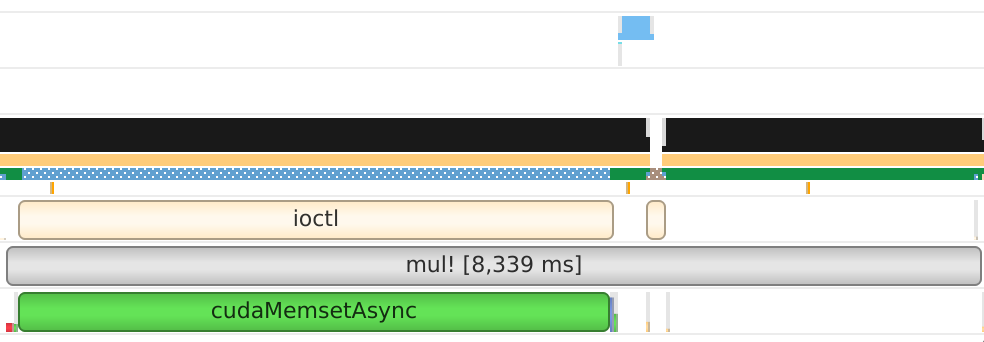

Note how our NVTX range nicely includes the time it took to queue the operation, as well as the execution on the GPU. This requires the NVTX range to include a synchronization!

The initial API call here is suspiciously slow though. This is a common occurence, and therefore it's recommended to profile any short-running application twice:

In [3]:
CUDA.@profile begin
    NVTX.@range "mul! 1" CUDA.@sync A * B
    NVTX.@range "mul! 2" CUDA.@sync A * B
end;


waiting for capture range to start the collection
command ignored
┌ Info: Profiling has finished, open the report listed above with `nsight-sys`
└ @ CUDA.Profile /home/tim/Julia/pkg/CUDA/lib/cudadrv/profile.jl:91


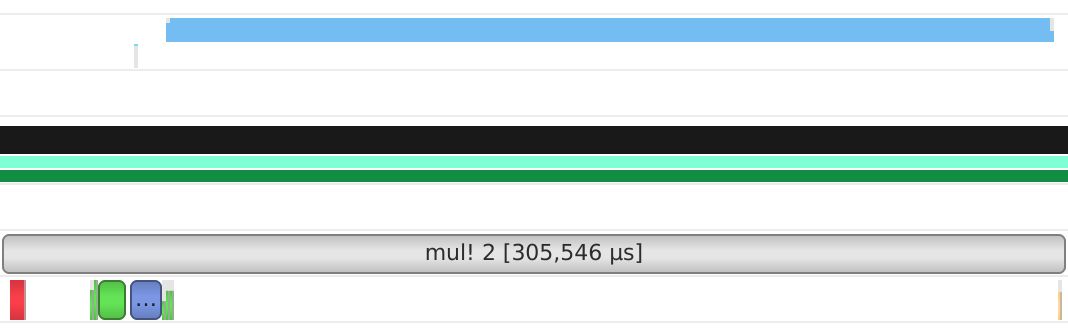

That's better, and much closer to our earlier benchmark results. Notice that it is still slightly slower, and some overhead is to be expected when running under the profiler.

NVTX can also be used to add markers to the source code:

In [4]:
CUDA.@profile begin
    NVTX.@range "mul! 1" CUDA.@sync A * B
    NVTX.@range "mul! 2" CUDA.@sync A * B
    NVTX.mark("done")
end;


waiting for capture range to start the collection
command ignored
┌ Info: Profiling has finished, open the report listed above with `nsight-sys`
└ @ CUDA.Profile /home/tim/Julia/pkg/CUDA/lib/cudadrv/profile.jl:91


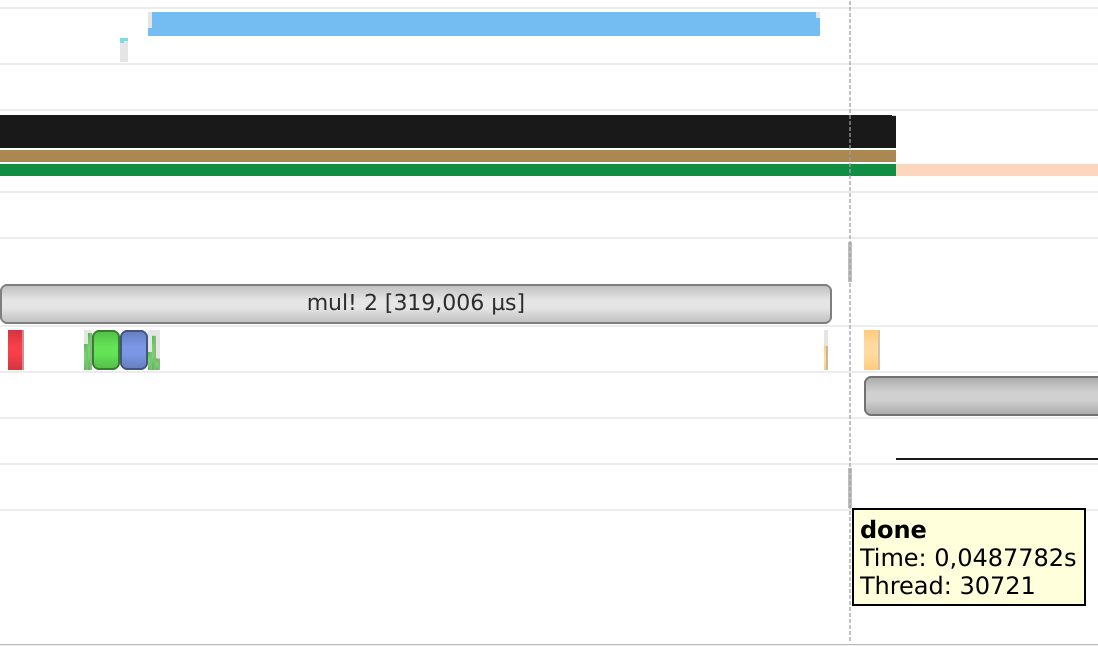

For details on the kernel's execution, expand the `GPU` part of the timeline and hover the kernel in question:

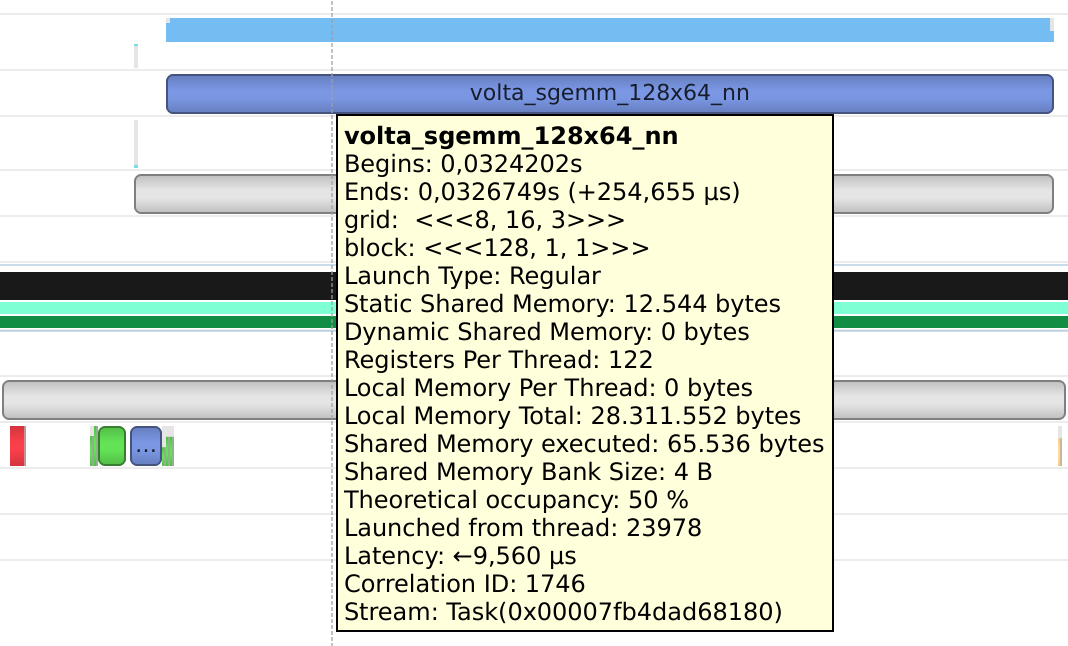

## Case study: application optimization

In [3]:
NVTX.@range function rmse(A::AbstractMatrix, B::AbstractMatrix)
    E = A - B
    SQE = E .^ 2
    MSE = sum(SQE) / length(SQE)
    return sqrt(MSE)
end

rmse (generic function with 1 method)

In [29]:
CUDA.allowscalar(false)
N = 16
A = CUDA.rand(1024, 1024, N)
B = CUDA.rand(1024, 1024, N)

NVTX.@range function doit(f)
    rmses = Vector{Float64}(undef, N)
    for i in 1:N
        rmses[i] = f(A[:, :, i], B[:, :, i])
    end
    rmses
end

b = @benchmark doit(rmse)
#CUDA.@profile doit(rmse)
b

BenchmarkTools.Trial: 537 samples with 1 evaluation.
 Range (min … max):  2.921 ms … 277.111 ms  ┊ GC (min … max): 0.00% … 1.21%
 Time  (median):     3.553 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.338 ms ±  38.805 ms  ┊ GC (mean ± σ):  0.72% ± 0.17%

  █                                                            
  █▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆ ▆
  2.92 ms      Histogram: log(frequency) by time       276 ms <

 Memory estimate: 114.97 KiB, allocs estimate: 2706.

no CUDA.@sync, because memcpy is synchronizing

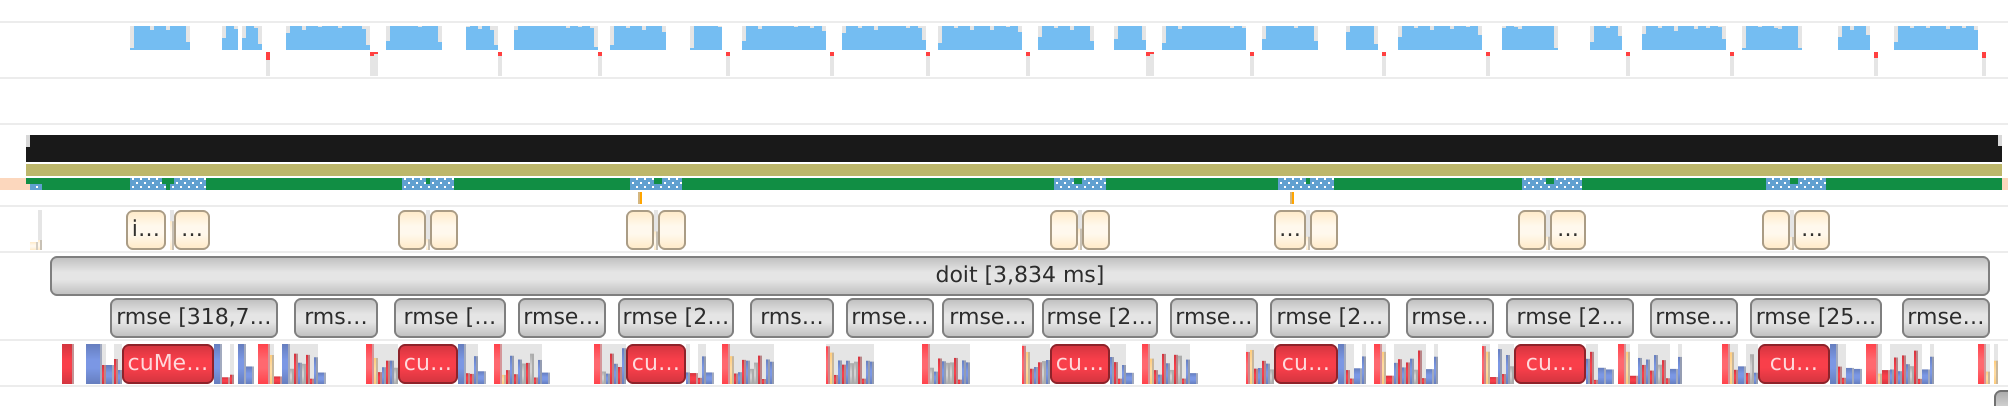

In [30]:
NVTX.@range function doit2(f)
    rmses = Vector{Float64}(undef, N)
    for i in 1:N
        rmses[i] = f(view(A, :, :, i), view(B, :, :, i))
    end
    rmses
end

b = @benchmark doit2(rmse)
#CUDA.@profile doit(rmse)
b

BenchmarkTools.Trial: 1052 samples with 1 evaluation.
 Range (min … max):  1.836 ms … 284.380 ms  ┊ GC (min … max): 0.00% … 1.41%
 Time  (median):     2.019 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.750 ms ±  26.407 ms  ┊ GC (mean ± σ):  0.80% ± 0.14%

   ▁ █▃  ▂▁▂▃▁▁▃▂                                              
  ██▄██▆▅████████▄▅▄▅▁▁▁▁▁▄▄▁▁▁▁▁▁▁▁▁▁▄▁▁▁▄▁▄▁▁▁▄▁▄▁▁▁▄▁▁▁▁▁▄ ▇
  1.84 ms      Histogram: log(frequency) by time      4.66 ms <

 Memory estimate: 76.97 KiB, allocs estimate: 1522.

In [31]:
NVTX.@range function rmse2(A::AbstractMatrix, B::AbstractMatrix)
    SQE = (A - B) .^ 2
    MSE = sum(SQE) / length(A)
    return sqrt(MSE)
end
b = @benchmark doit2(rmse2)
#CUDA.@profile doit2(rmse2)
b

BenchmarkTools.Trial: 1010 samples with 1 evaluation.
 Range (min … max):  1.843 ms … 278.905 ms  ┊ GC (min … max): 0.00% … 1.49%
 Time  (median):     2.030 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.948 ms ±  27.220 ms  ┊ GC (mean ± σ):  0.83% ± 0.15%

  █                                                            
  █▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂ ▂
  1.84 ms         Histogram: frequency by time        54.8 ms <

 Memory estimate: 76.97 KiB, allocs estimate: 1522.

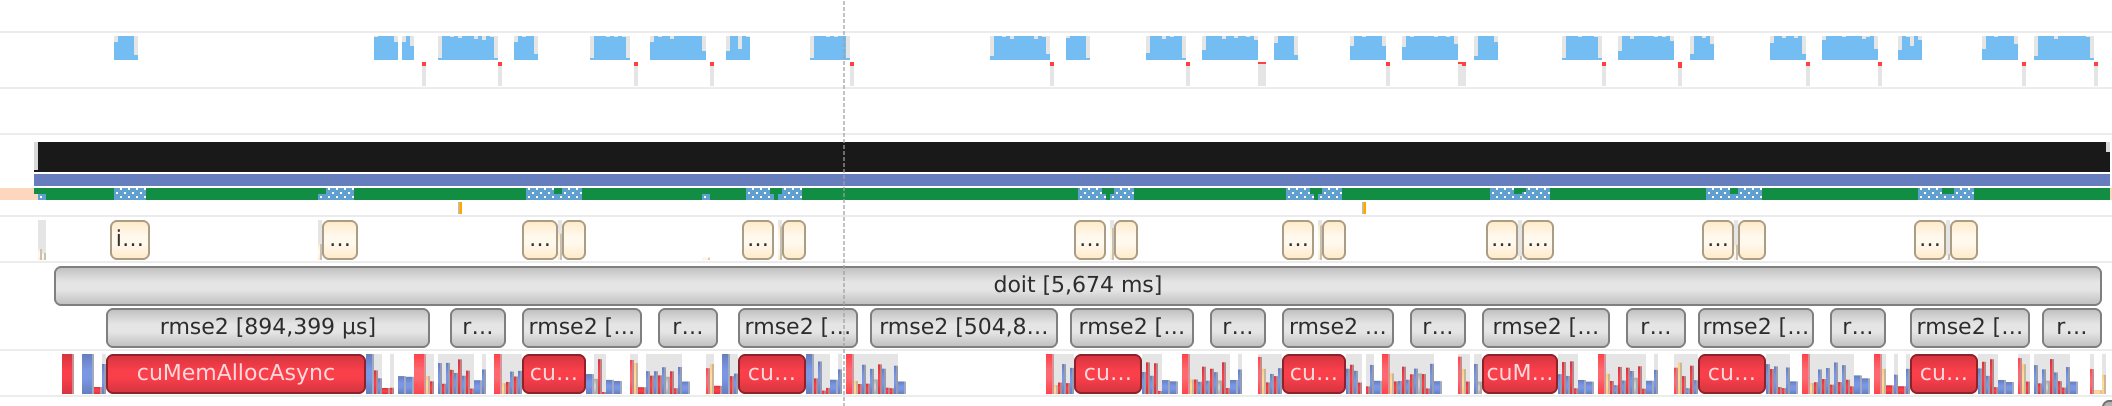

In [32]:
NVTX.@range function rmse3(A::AbstractMatrix, B::AbstractMatrix)
    @assert size(A) == size(B)
    MSE = mapreduce((a,b)->(a - b) ^ 2, +, A, B) / length(A)
    return sqrt(MSE)
end
b = @benchmark doit2(rmse3)
#CUDA.@profile doit2(rmse3)
b

BenchmarkTools.Trial: 5235 samples with 1 evaluation.
 Range (min … max):  802.001 μs … 48.730 ms  ┊ GC (min … max): 0.00% … 27.06%
 Time  (median):     829.831 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   952.662 μs ±  1.705 ms  ┊ GC (mean ± σ):  1.78% ±  0.98%

  ██▁        ▁▃▂   ▁▂▂                                         ▁
  ███▄▄▄▁▄▄▄▄███▇▆▅████▅▄▅▆▄▃▁▄▁▃▄▃▁▃▁▁▃▁▁▁▁▁▃▁▁▁▃▃▁▁▁▁▁▁▁▁▁▁▃ █
  802 μs        Histogram: log(frequency) by time       2.4 ms <

 Memory estimate: 61.97 KiB, allocs estimate: 1218.

In [43]:
NVTX.@range function rmse4(A::AbstractMatrix, B::AbstractMatrix)
    @assert size(A) == size(B)
    MSE = mapreduce((a,b)->(a - b) ^ 2, +, A, B; dims=(1,2)) ./ length(A)
    return sqrt.(MSE)
end

NVTX.@range function doit3(f)
    rmses = Vector(undef, N)
    for i in 1:N
        rmses[i] = f(view(A, :, :, i), view(B, :, :, i))
    end
    map(rmses) do rmse
        Array(rmse)[]
    end
end

#b = @benchmark doit3(rmse4)
#CUDA.@profile doit3(rmse4)
#b
doit3(rmse4)

typeof(R) = CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}
size(R) = (1, 1)
typeof(A) = Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{2}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}, var"#76#77", Tuple{CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}}
size(A) = (1024, 1024)
typeof(R) = CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}
size(R) = (1, 1, 1)
typeof(A) = CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}
size(A) = (1, 1, 48)
typeof(R) = CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}
size(R) = (1, 1)
typeof(A) = Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{2}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}, var"#76#77", Tuple{CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}}
size(A) = (1024, 1024)
typeof(R) = CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}
size(R) = (1, 1, 1)
typeof(A) = CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}
size(A) = (1, 1, 48)
typeof(R) = CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}
size(R) = (1, 1)
typeof(A

16-element Vector{Float32}:
 0.40819794
 0.40824947
 0.40832016
 0.40772977
 0.40824547
 0.40791473
 0.40810397
 0.4083595
 0.408447
 0.40815404
 0.4085505
 0.40849838
 0.40851662
 0.40797493
 0.40841326
 0.4080057

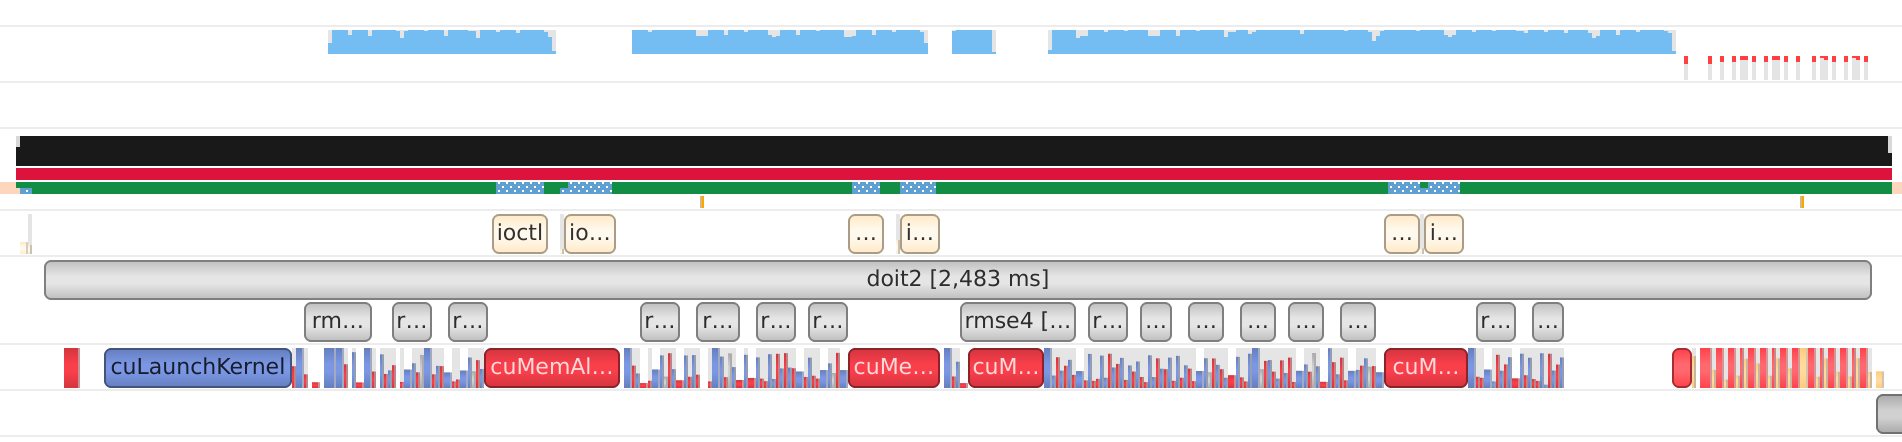

In [49]:
NVTX.@range function rmse5(A::AbstractMatrix, B::AbstractMatrix, C::AbstractArray)
    SQE = Broadcast.broadcasted(A, B) do a,b
        (a - b) ^ 2
    end
    SQE = Broadcast.instantiate(SQE)
    MSE = Base.mapreducedim!(identity, +, C, SQE)
    C .= sqrt.(C ./ length(SQE))
    return
end

NVTX.@range function doit4(f)
    rmses = CuVector{Float64}(undef, N)
    for i in 1:N
        f(view(A, :, :, i), view(B, :, :, i), reshape(view(rmses, i), 1, 1))
    end
    Array(rmses)
end

b = @benchmark doit4(rmse5)
#CUDA.@profile doit4(rmse5)
b

BenchmarkTools.Trial: 2258 samples with 1 evaluation.
 Range (min … max):  2.074 ms … 50.510 ms  ┊ GC (min … max): 0.00% … 30.64%
 Time  (median):     2.130 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.213 ms ±  1.437 ms  ┊ GC (mean ± σ):  0.57% ±  0.85%

   ▃▆▇█▇▇▆▅▄▃▁▁ ▁ ▁▁                                         ▁
  ▇██████████████▇██▇█▇▇▆▇▆██▇▇▇▇▇▇▆▆▅▄▆▇▆▇▅▆▆▆▇▆▆▆▅▆▄▄▅▄▃▄▄ █
  2.07 ms      Histogram: log(frequency) by time     2.63 ms <

 Memory estimate: 56.55 KiB, allocs estimate: 1075.

Waarom is dit traag? geen idee. ligt dus niet aan de broadcasted, dus mag weg (gewoon dense). somehow zijn er massas D2D copies :/